# Auto Labeling
This notebook reads the computed fft results for each part and plots the response over the time varing waveform for visual inspection.

In [81]:
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import os
import sys

In [167]:
wav_directory = r'/Users/reecerobinson/Library/Mobile Documents/com~apple~CloudDocs/Data Sets/Audio Recognition/Washing Machine Completion/parts/'
fft_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/washing-machine-alert/fft/'
pos_response_sample_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/washing-machine-alert/pos-response-samples/'

if not os.path.exists(pos_response_sample_directory):
    os.makedirs(pos_response_sample_directory)

In [122]:
duration = 0.15 # window length in seconds
sample_rate = 16000
sample_size = 2400 # 150 ms window size
stride = 80 # sliding 5 ms window increments

In [123]:
from os.path import isfile, join

def list_files(base_dir, ext):
    onlyfiles = [f for f in os.listdir(base_dir) if isfile(join(base_dir, f)) and f.split('.')[-1] == ext]
    return onlyfiles

wav_files = list_files(wav_directory,'wav')
print(wav_files)

['161225-000_16bit-part-0.wav', '161225-000_16bit-part-1.wav', '161225-000_16bit-part-2.wav', '161225-000_16bit-part-3.wav', '161225-000_16bit-part-4.wav', '161225-000_16bit-part-5.wav', '161225-000_16bit-part-6.wav', '161225-001_16bit-part-0.wav', '161225-001_16bit-part-1.wav', '161225-001_16bit-part-10.wav', '161225-001_16bit-part-2.wav', '161225-001_16bit-part-3.wav', '161225-001_16bit-part-4.wav', '161225-001_16bit-part-5.wav', '161225-001_16bit-part-6.wav', '161225-001_16bit-part-7.wav', '161225-001_16bit-part-8.wav', '161225-001_16bit-part-9.wav', '161225-002_16bit-part-0.wav', '161225-003_16bit-part-0.wav', '161225-004_16bit-part-0.wav', '161225-005_16bit-part-0.wav', '161225-006_16bit-part-0.wav', '161225-006_16bit-part-1.wav', '161225-006_16bit-part-2.wav']


In [124]:
fft_compressed_files = list_files(fft_directory,'gz')
print(fft_compressed_files)

['161225-000_16bit-part-0.wav-fft.csv.gz', '161225-000_16bit-part-1.wav-fft.csv.gz', '161225-000_16bit-part-2.wav-fft.csv.gz', '161225-000_16bit-part-3.wav-fft.csv.gz', '161225-000_16bit-part-4.wav-fft.csv.gz', '161225-000_16bit-part-5.wav-fft.csv.gz', '161225-000_16bit-part-6.wav-fft.csv.gz', '161225-001_16bit-part-0.wav-fft.csv.gz', '161225-001_16bit-part-1.wav-fft.csv.gz']


### Each fft row represents the discrete FFT analysis for a 150 ms window of the input signal. Each observation window starts 5 ms apart.

In [192]:
def label_observations(df, x_all, positive_threshold):

    label_window_start = 1190
    label_window_end = 1210
    
    # Ignore the first section of the frequencies as these are not relevant 
    # and have relatively large values compared with the signal of interest.

    cols = np.arange(label_window_start,label_window_end)
    sub_df = df.iloc[:,cols]

    # ### Observations with power values over positive_threshold dB are assigned a True Positive Response

    df['response'] =(sub_df.loc[:,cols].max(axis=1) > positive_threshold)
    df['x_axis'] = [x for x in np.arange(0,len(x_all)-sample_size,stride)]

    return df

def save_wav(filename, df, x_all):
    # # Output Training Data
    positive_label_data = df[df['response'] == True].drop('response',axis=1)
    print ('\nPositive Response: %s,%s'%(positive_label_data.shape))

    # Positive Samples
    w_size = stride
    for idx in positive_label_data.index:
        begin = idx * w_size 
        librosa.output.write_wav(pos_response_sample_directory+filename+'positive_sample_%s.wav'%idx,x_all[begin:begin+sample_size], sample_rate)

In [169]:
%%time
test_file = '161225-001_16bit-part-9'
df = pd.read_csv(fft_directory+test_file+'.wav-fft.csv.gz')
cols = np.arange(0,sample_size).tolist()
df.columns=cols
print(df.head())

        0          1          2         3          4         5         6     \
0  26.209188  21.623608 -10.358844  6.586753  -7.028095  1.600575 -2.595378   
1  26.235341  21.709357  -9.568472  6.962870 -13.328078  2.581967 -9.131612   
2  26.278463  21.769437  -9.452969  6.770949 -39.410058 -4.097223  1.389082   
3  26.309322  21.846578  -9.775923  5.997091 -23.744251 -7.712294  1.630375   
4  26.332802  21.924907 -11.068608  5.241501 -25.522109  0.960066 -5.601819   

       7         8         9       ...           2390       2391       2392  \
0  6.081511  3.267589  2.665152    ...     -80.474727 -56.087371 -67.076406   
1  7.777575 -4.011587  3.869437    ...     -66.687277 -61.855881 -57.571312   
2  0.777063  7.331400 -0.322932    ...     -61.135799 -71.700634 -56.820794   
3  1.119996  7.259189 -7.944921    ...     -69.064392 -59.416784 -61.496885   
4  7.842555 -6.098834  6.155300    ...     -63.785180 -58.053241 -86.751586   

        2393       2394       2395       2396     

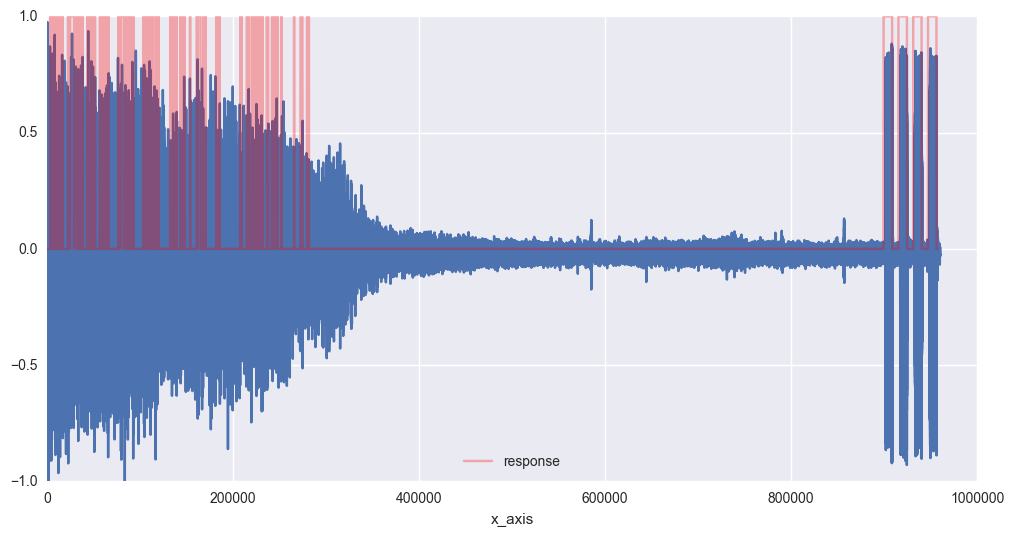

False    10683
True      1287
Name: response, dtype: int64


In [194]:
filename = test_file+'.wav'
threshold = 5

x_all, sr = librosa.load(wav_directory+filename, sr=sample_rate)

df_response = label_observations(df,x_all,threshold)

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(x_all)
df_response[['x_axis','response']].plot(x='x_axis',y='response',c='r',ax=ax, alpha=0.3)

plt.xlim(0,1000000)
plt.ylim(-1,1)
plt.show()
print(df_response['response'].value_counts())

In [183]:
from IPython.display import Audio
Audio(x_all, rate=sample_rate)

### Look at the fft analysis for a sample.

In [184]:
df_response[df_response['response'] == True]

,0,1,2,3,4,5,6,7,8,9,...,2392,2393,2394,2395,2396,2397,2398,2399,response,x_axis
11246,26.226969,21.693062,-17.658220,5.144759,-13.634268,-21.570009,-24.392578,-17.645250,-3.693226,-16.681391,...,-66.033556,-100.844981,-73.009026,-76.986542,-73.412362,-94.154588,-77.407130,-81.451619,True,899680
11247,26.222397,21.661525,-20.428775,4.841943,-18.325030,-36.114125,-35.073676,-5.849286,-6.532409,-3.010212,...,-75.592417,-79.568687,-77.650099,-86.236836,-71.700350,-86.607275,-76.007828,-79.953539,True,899760
11248,26.219457,21.645230,-26.924627,4.733427,-33.358606,-59.660665,-21.319389,-3.158536,-13.916299,-1.107055,...,-69.577061,-80.559226,-106.445996,-85.332686,-71.220965,-78.283354,-76.486603,-78.939978,True,899840
11249,26.215990,21.650880,-44.250619,4.808921,-21.868320,-18.187444,-18.433686,-14.144371,-2.788509,-8.497127,...,-64.849942,-94.166040,-91.579918,-75.435472,-71.996324,-74.717243,-79.236423,-77.998219,True,899920
11250,26.212538,21.674885,-27.183106,5.088604,-15.192329,-12.108273,-39.638529,-5.523621,-4.917503,-6.122894,...,-69.474256,-80.241016,-81.104550,-71.006349,-74.996645,-73.122694,-87.227734,-77.432116,True,900000
11251,26.211210,21.706232,-24.615325,5.572620,-12.536742,-12.161263,-14.178830,-2.177233,-17.084915,0.712887,...,-73.192906,-105.241301,-71.895745,-68.832483,-86.330000,-72.846663,-89.145677,-77.593222,True,900080
11252,26.211079,21.736808,-26.117546,6.151459,-12.368985,-22.769516,-8.888435,-10.087311,-2.814195,-3.709396,...,-63.377583,-72.096411,-70.693141,-68.410244,-77.953363,-74.106251,-79.143595,-78.226022,True,900160
11253,26.210088,21.760389,-34.829332,6.661822,-15.103199,-14.467664,-9.046996,-7.730138,-3.816559,-4.060560,...,-63.444912,-65.928345,-81.988475,-70.385377,-70.142991,-77.401765,-75.603221,-79.467882,True,900240
11254,26.207184,21.771002,-30.984448,6.962497,-25.800708,-8.334510,-15.820399,-2.922902,-33.555700,2.653254,...,-76.527059,-65.320976,-69.708232,-78.126882,-66.964491,-85.596525,-74.559215,-81.203838,True,900320
11255,26.202275,21.764778,-22.033502,6.964925,-19.990757,-7.946339,-19.376433,-8.641147,-5.662181,-5.794436,...,-64.831406,-72.406812,-63.093399,-78.374910,-66.421901,-89.433319,-75.512482,-83.036793,True,900400


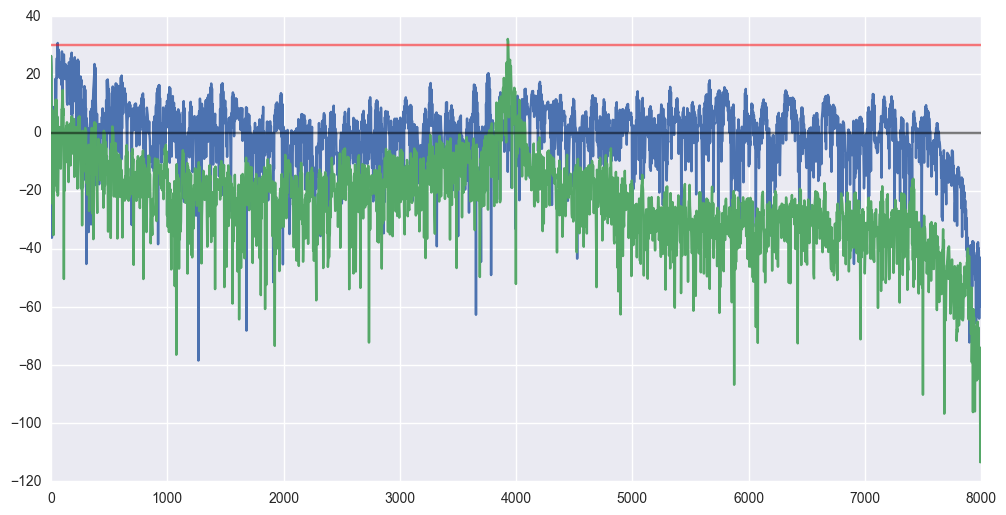

In [186]:
T = 1.0/sample_rate
freqs = np.linspace(0.0, 1.0/(2.0*T), sample_size)
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(freqs,df.iloc[3417].drop(['response','x_axis']))
plt.plot(freqs,df.iloc[11947].drop(['response','x_axis']))

ax.axhline(threshold,c='r',alpha=0.5)
ax.axhline(0,c='k',alpha=0.5)

plt.show()